In [1]:
import matplotlib.pylab as plt
import numpy as np
plt.style.use("/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")
%config InlineBackend.figure_format = 'svg'
import sys
import os
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")

path_sav_fig = f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/eESAndpESDiscrimination/figure/"
if not os.path.isdir(path_sav_fig):
    os.mkdir(path_sav_fig)

key_Energy = "Erec"
key_tag = "evtType"
dir_map_tags = {0:"pES", 1:"eES"}

# Load Prediction Outputs
with np.load(f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/eESAndpESDiscrimination/predict_Combine.npz",
             allow_pickle=True) as f:
    dir_events = f["dir_events"].item()
    dir_train = f["dir_train"].item()


# Erec_max = max( dir_events[key_Energy] )
Erec_max = 12.5
# dir_diff_option_for_events = {"Without IBDp":dir_events}
dir_diff_option_for_events = {"With IBDp":dir_events}
print(dir_events[key_Energy])

[0.27822322 0.17498729 0.20244557 ... 0.18072918 0.37840062 0.38591179]


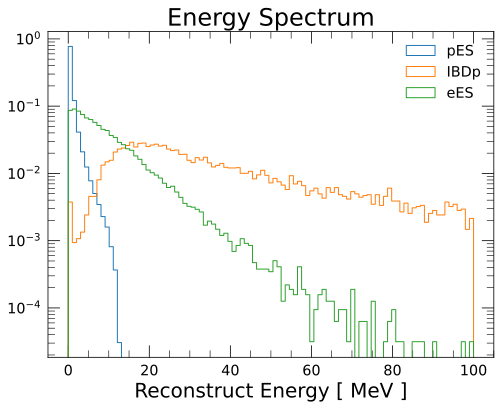

In [2]:
bins_equen= np.linspace(0, 100 ,100)
for tag in set(dir_events[f"{key_tag}(Truth)"]):
    plt.hist(dir_events[key_Energy][dir_events[f"{key_tag}(Truth)"]==tag],bins=bins_equen, histtype="step", label=tag,
             density=True)
plt.xlabel("Reconstruct Energy [ MeV ]")
plt.title("Energy Spectrum")
plt.semilogy()
plt.legend()


dict_keys(['evtID', 'h_time_without_charge', 'h_time_with_charge', 'XYZ', 'Erec', 'evtID_PSD', 'evtType', 'R3', 'evtType(Truth)', 'PSD'])
dict_keys(['evtID', 'h_time_without_charge', 'h_time_with_charge', 'XYZ', 'Erec', 'evtID_PSD', 'evtType', 'R3', 'evtType(Truth)', 'PSD'])
{'train': Counter({0: 31903, 1: 31903}), 'test': Counter({0: 323592, 1: 38994}), 'total': Counter({0: 355495, 1: 70897})}
dict_keys(['evtID', 'h_time_without_charge', 'h_time_with_charge', 'XYZ', 'Erec', 'evtID_PSD', 'evtType', 'R3', 'evtType(Truth)'])
Counter({'pES': 31903, 'eES': 25730, 'IBDp': 6173})


,pES,eES,IBDp
Train,31903,25730,6173
Test,323592,31448,7546


PSD Cut: 0.441
Optimized  Efficiency:
 pES inefficiency:	 1.000  +- 0.017 % 
eES/IBDp efficiency:	 97.745  +- 0.056 %

Optimized  Ratio of Residue:
 pES Ratio:	 4.880 +- 0.08 % 
eES/IBDp Ratio:	 95.120 +- 0.08 %

##############################################



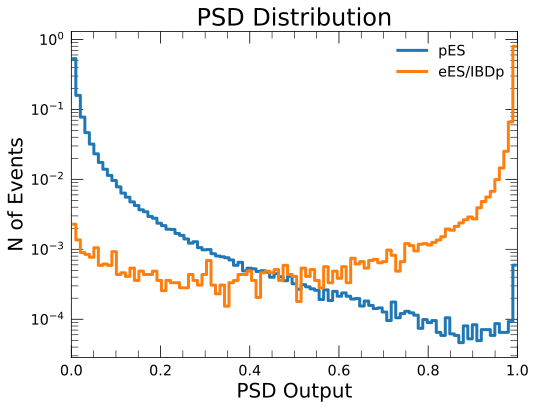

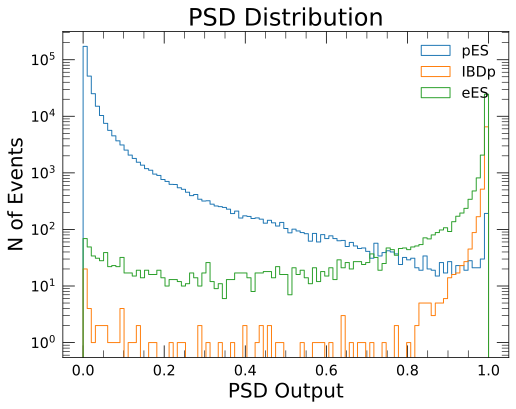

<Figure size 576x432 with 0 Axes>

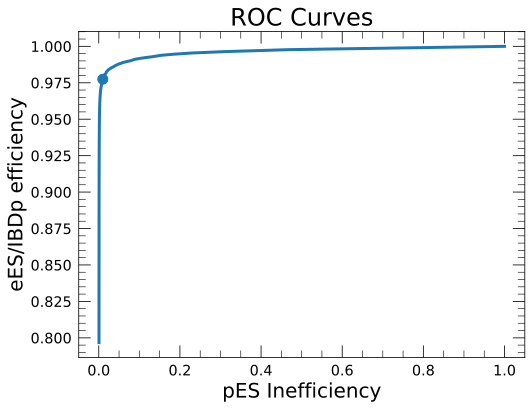

In [45]:
from importlib import reload
import DiscriminationTools
reload(DiscriminationTools)
from DiscriminationTools import  DiscriminationTools
discrimination_tool = DiscriminationTools(key_0="pES", key_1="eES/IBDp")

print(dir_events.keys())

discrimination_tool.GetPredictionData("/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/eESAndpESDiscrimination/predict_Combine.npz")

discrimination_tool.PrintSamplesInformation()
discrimination_tool.GetPSDDistribution()
discrimination_tool.PlotROCCurves()
discrimination_tool.MaximumSignificance(v_bkg_ineff=np.linspace(0.01, 0.2,1000), condition="Total Samples", set_global_PSD_cut=True)




PSD Cut: 0.441
Certain PSD Cut  Efficiency:
 pES inefficiency:	 0.787  +- 0.027 % 
eES/IBDp efficiency:	 43.993  +- 1.6 %

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 67.306 +- 1.3 % 
eES/IBDp Ratio:	 32.694 +- 1.3 %

##############################################

PSD Cut: 0.441
Certain PSD Cut  Efficiency:
 pES inefficiency:	 0.828  +- 0.037 % 
eES/IBDp efficiency:	 67.773  +- 1.5 %

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 43.650 +- 1.5 % 
eES/IBDp Ratio:	 56.350 +- 1.5 %

##############################################

PSD Cut: 0.441
Certain PSD Cut  Efficiency:
 pES inefficiency:	 0.805  +- 0.046 % 
eES/IBDp efficiency:	 79.475  +- 1.3 %

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 29.376 +- 1.4 % 
eES/IBDp Ratio:	 70.624 +- 1.4 %

##############################################

PSD Cut: 0.441
Certain PSD Cut  Efficiency:
 pES inefficiency:	 0.735  +- 0.054 % 
eES/IBDp efficiency:	 84.753  +- 1.2 %

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 19.804 +- 1.3 % 
eE

/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/DiscriminationTools.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_PSD,ax_PSD = plt.subplots(1,1)


PSD Cut: 0.441
Certain PSD Cut  Efficiency:
 pES inefficiency:	 0.552  +- 0.075 % 
eES/IBDp efficiency:	 95.972  +- 0.68 %

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 6.406 +- 0.84 % 
eES/IBDp Ratio:	 93.594 +- 0.84 %

##############################################

PSD Cut: 0.441
Certain PSD Cut  Efficiency:
 pES inefficiency:	 0.371  +- 0.069 % 
eES/IBDp efficiency:	 96.825  +- 0.61 %

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 3.477 +- 0.64 % 
eES/IBDp Ratio:	 96.523 +- 0.64 %

##############################################

PSD Cut: 0.441
Certain PSD Cut  Efficiency:
 pES inefficiency:	 0.458  +- 0.085 % 
eES/IBDp efficiency:	 97.763  +- 0.53 %

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 3.557 +- 0.65 % 
eES/IBDp Ratio:	 96.443 +- 0.65 %

##############################################

PSD Cut: 0.441
Certain PSD Cut  Efficiency:
 pES inefficiency:	 0.394  +- 0.089 % 
eES/IBDp efficiency:	 98.762  +- 0.39 %

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 2.456 +- 0.5

PSD Cut: 0.441
Certain PSD Cut  Efficiency:
 pES inefficiency:	 0.629  +- 0.19 % 
eES/IBDp efficiency:	 100.000  +- 0 %

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 1.456 +- 0.44 % 
eES/IBDp Ratio:	 98.544 +- 0.44 %

##############################################

PSD Cut: 0.441
Certain PSD Cut  Efficiency:
 pES inefficiency:	 1.050  +- 0.26 % 
eES/IBDp efficiency:	 100.000  +- 0 %

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 2.281 +- 0.56 % 
eES/IBDp Ratio:	 97.719 +- 0.56 %

##############################################



Test Samples,index,eES/IBDp Eff.,pES Ineff.,(eES/IBDp Residue)/(Total Residue),(pES Residue)/(Total Residue),PSD Cut,N_eES/IBDp,N_pES
0,Total Samples,97.745 +- 0.056 %,1.000 +- 0.017 %,95.120 +- 0.08 %,4.880 +- 0.08 %,0.44,70897,355495
1,0.20 < Erec < 0.35 MeV,43.993 +- 1.6 %,0.787 +- 0.027 %,32.694 +- 1.3 %,67.306 +- 1.3 %,0.44,921,106043
2,0.35 < Erec < 0.49 MeV,67.773 +- 1.5 %,0.828 +- 0.037 %,56.350 +- 1.5 %,43.650 +- 1.5 %,0.44,939,59568
3,0.49 < Erec < 0.64 MeV,79.475 +- 1.3 %,0.805 +- 0.046 %,70.624 +- 1.4 %,29.376 +- 1.4 %,0.44,907,37247
4,0.64 < Erec < 0.79 MeV,84.753 +- 1.2 %,0.735 +- 0.054 %,80.196 +- 1.3 %,19.804 +- 1.3 %,0.44,864,24592
5,0.79 < Erec < 0.94 MeV,93.347 +- 0.85 %,0.547 +- 0.058 %,90.091 +- 1 %,9.909 +- 1 %,0.44,867,16259
6,0.94 < Erec < 1.08 MeV,92.298 +- 0.97 %,0.439 +- 0.06 %,92.988 +- 0.93 %,7.012 +- 0.93 %,0.44,762,12080
7,1.08 < Erec < 1.23 MeV,95.972 +- 0.68 %,0.552 +- 0.075 %,93.594 +- 0.84 %,6.406 +- 0.84 %,0.44,831,9884
8,1.23 < Erec < 1.38 MeV,96.825 +- 0.61 %,0.371 +- 0.069 %,96.523 +- 0.64 %,3.477 +- 0.64 %,0.44,816,7666
9,1.38 < Erec < 1.53 MeV,97.763 +- 0.53 %,0.458 +- 0.085 %,96.443 +- 0.65 %,3.557 +- 0.65 %,0.44,792,6240


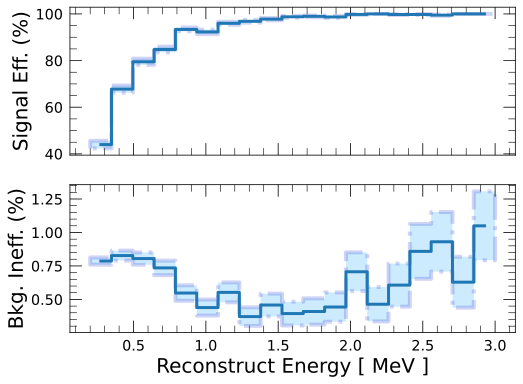

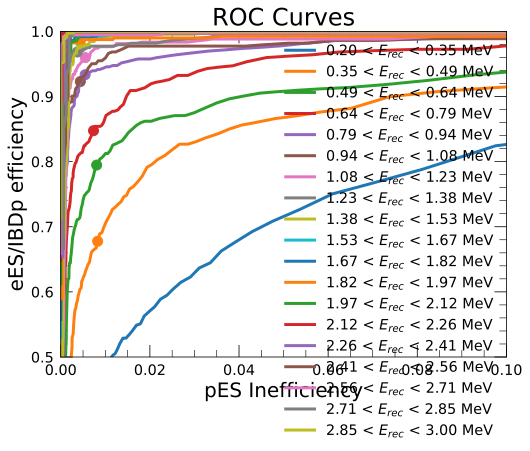

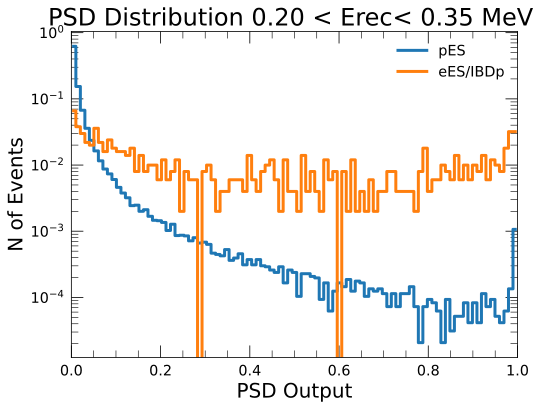

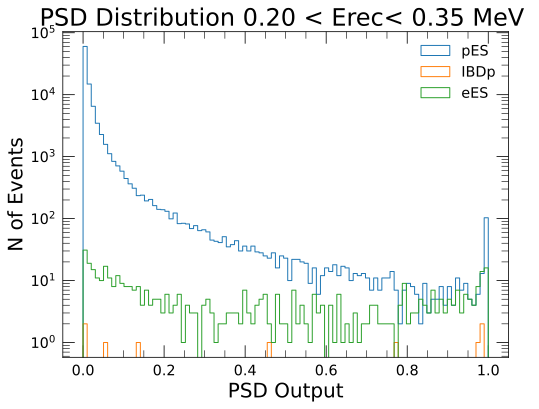

<Figure size 576x432 with 0 Axes>

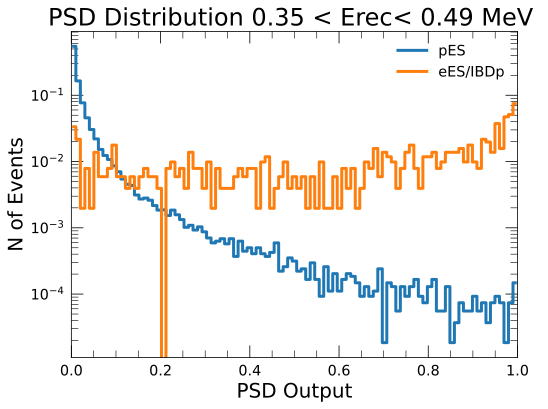

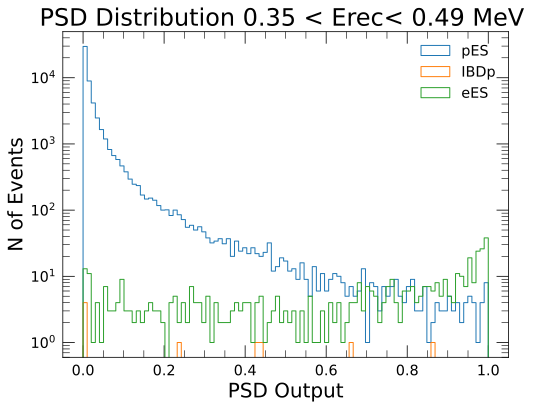

<Figure size 576x432 with 0 Axes>

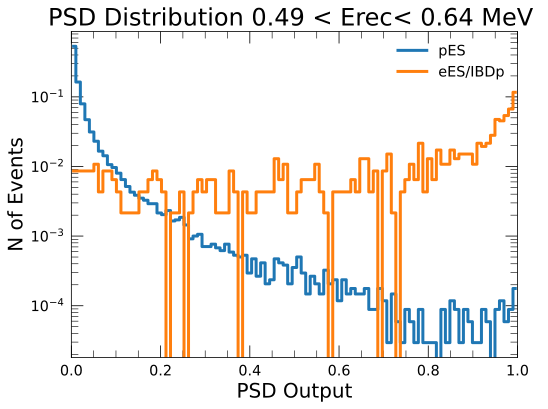

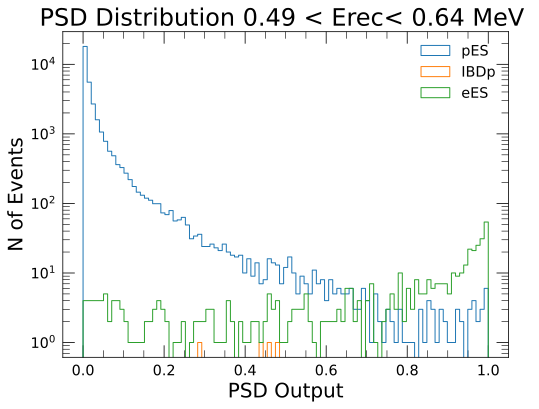

<Figure size 576x432 with 0 Axes>

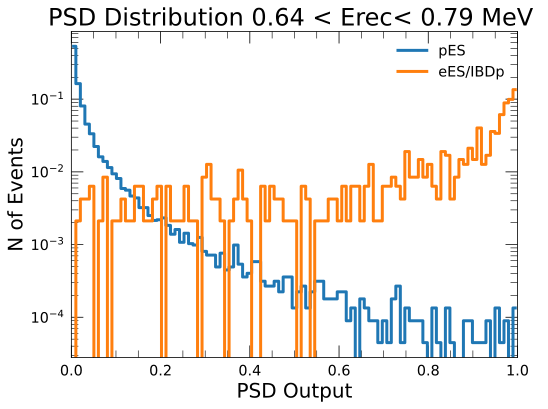

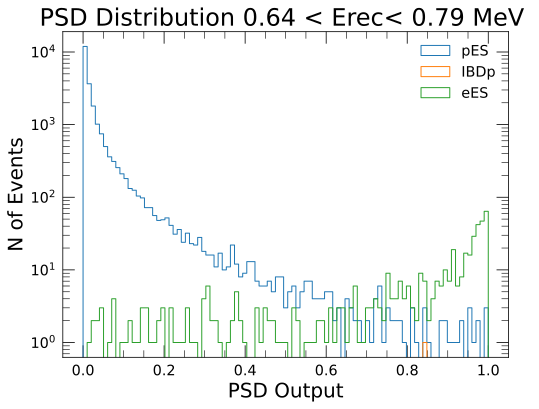

<Figure size 576x432 with 0 Axes>

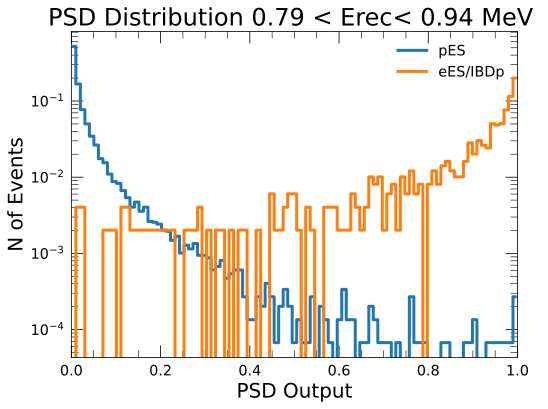

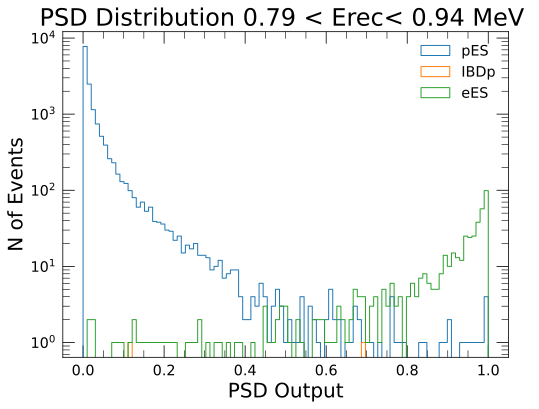

<Figure size 576x432 with 0 Axes>

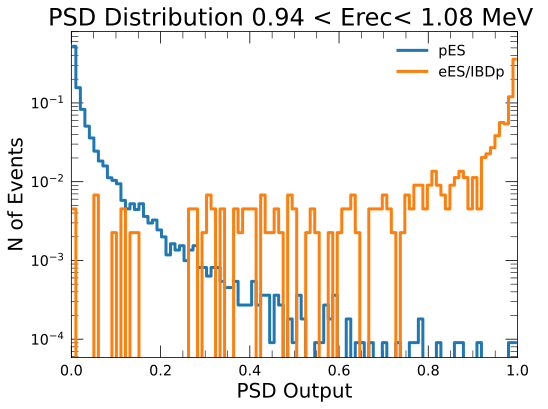

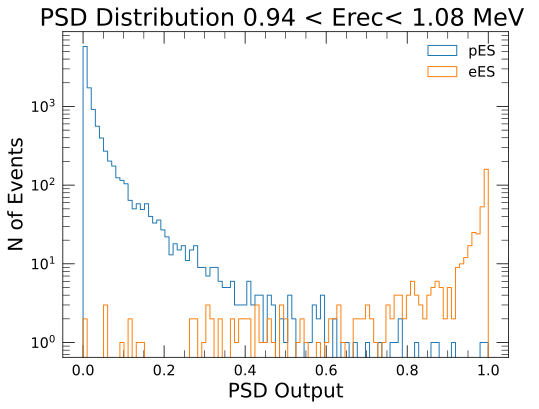

<Figure size 576x432 with 0 Axes>

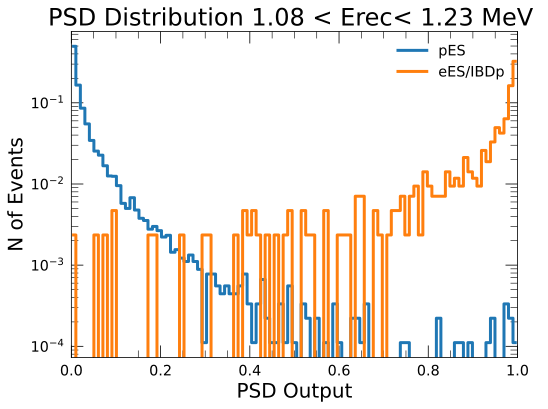

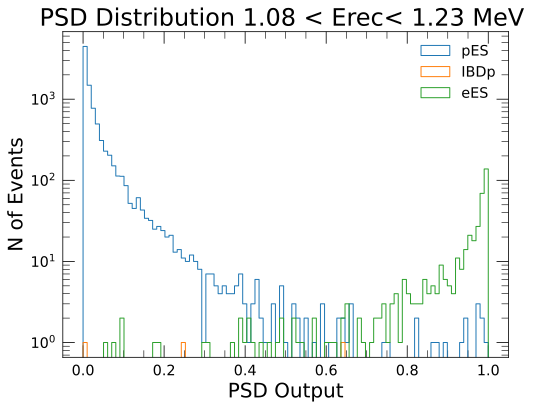

<Figure size 576x432 with 0 Axes>

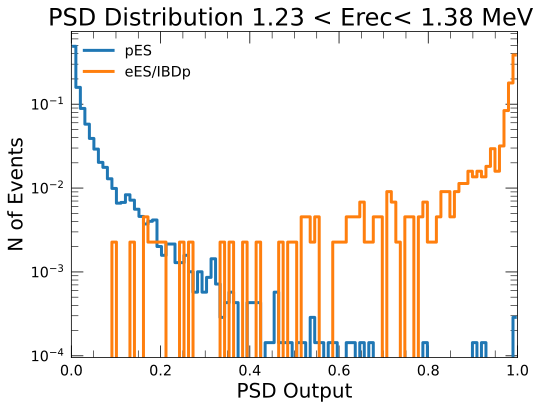

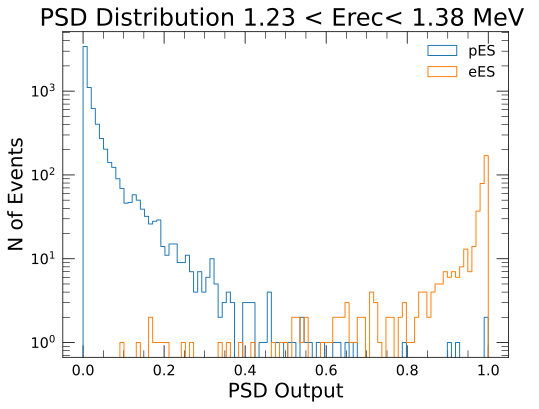

<Figure size 576x432 with 0 Axes>

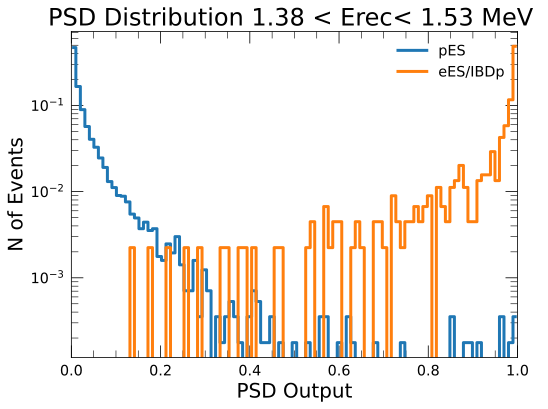

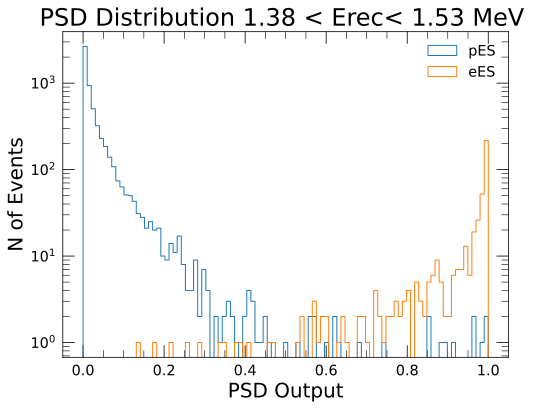

<Figure size 576x432 with 0 Axes>

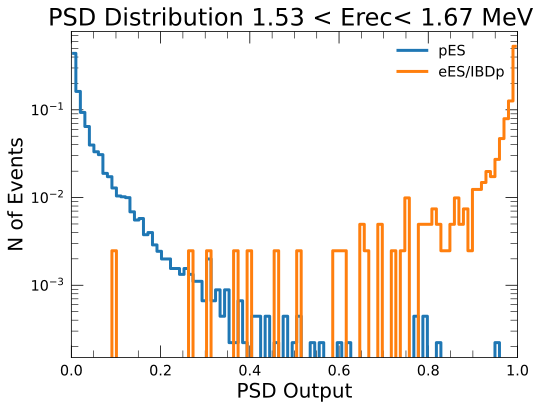

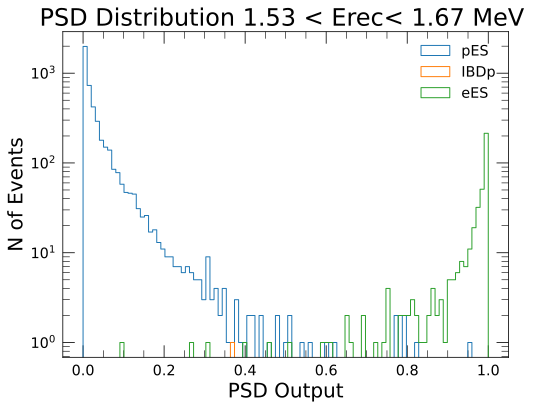

<Figure size 576x432 with 0 Axes>

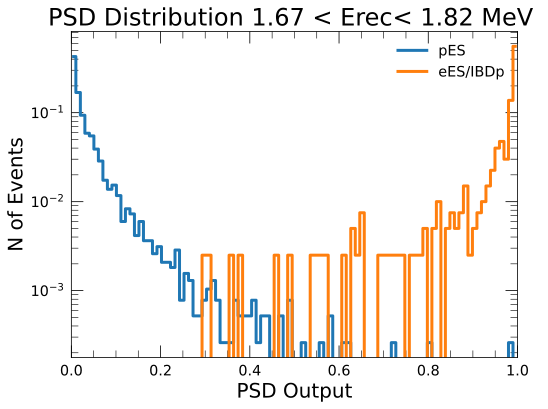

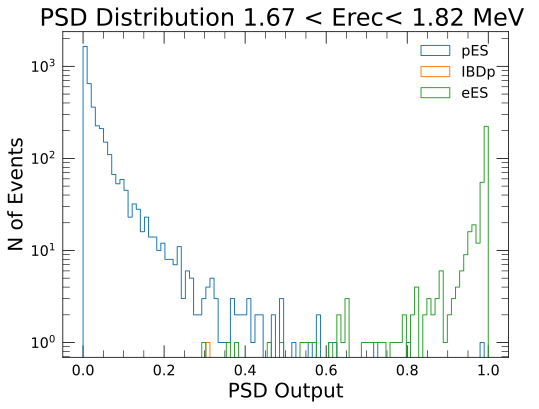

<Figure size 576x432 with 0 Axes>

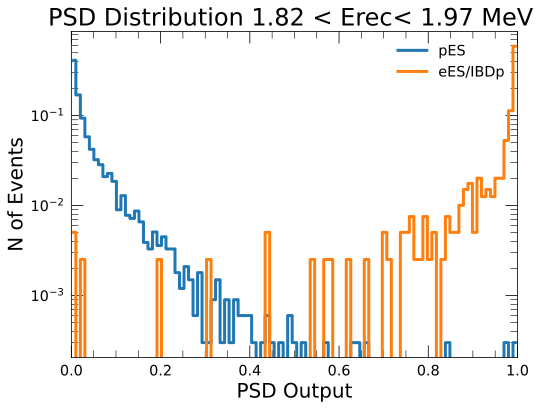

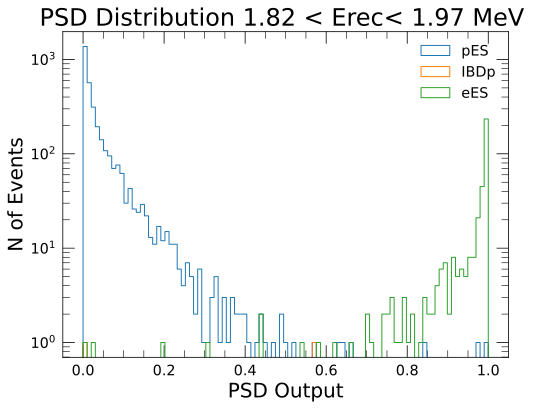

<Figure size 576x432 with 0 Axes>

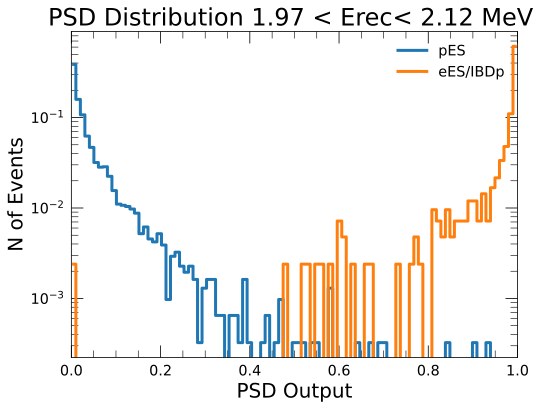

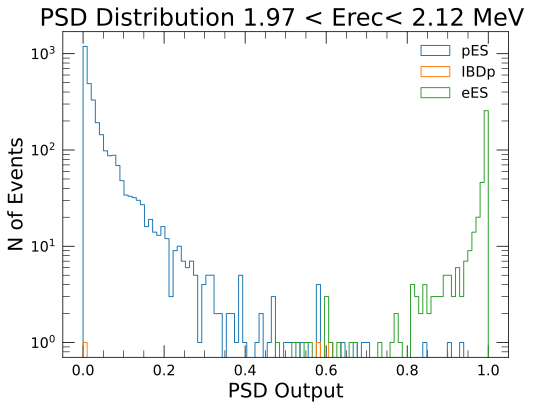

<Figure size 576x432 with 0 Axes>

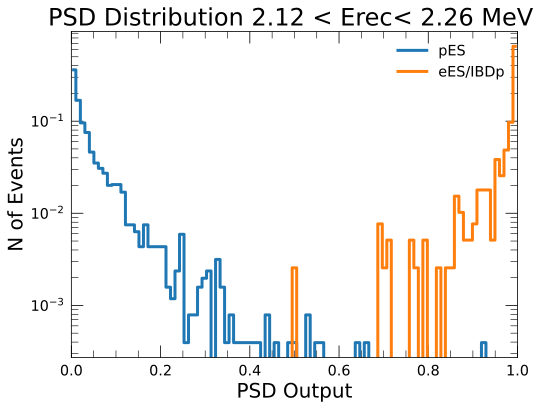

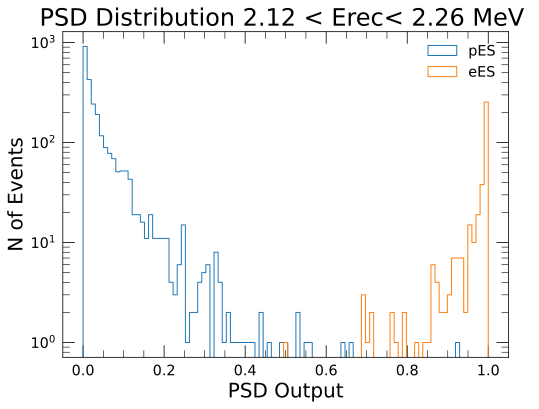

<Figure size 576x432 with 0 Axes>

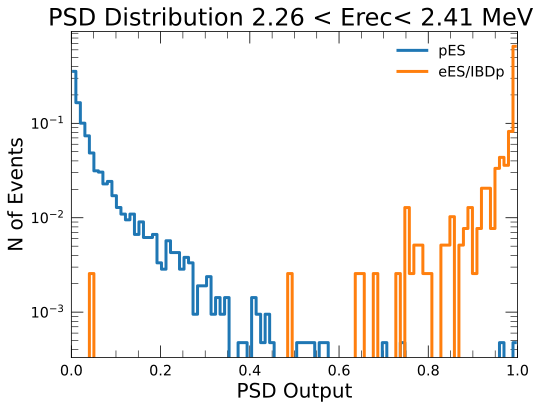

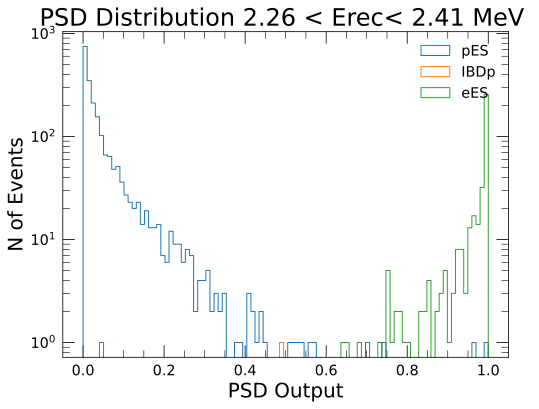

<Figure size 576x432 with 0 Axes>

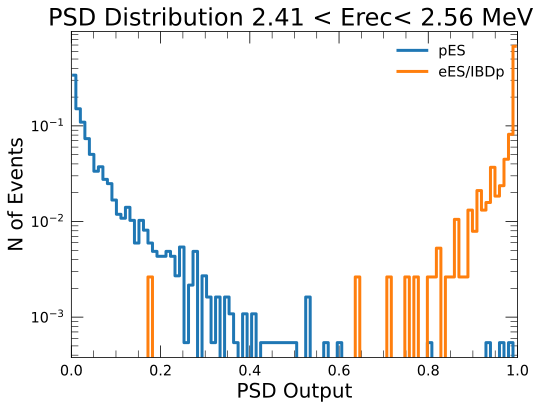

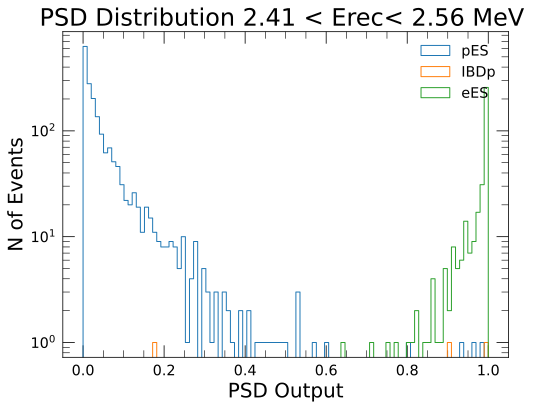

<Figure size 576x432 with 0 Axes>

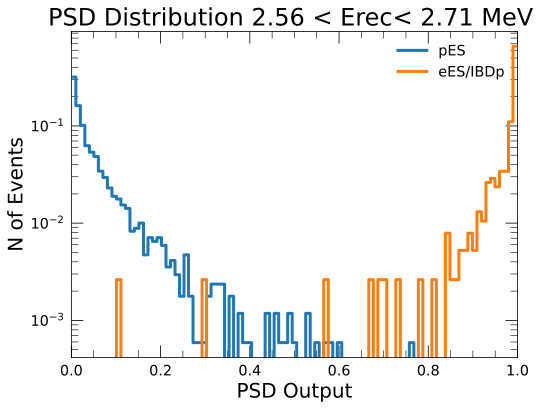

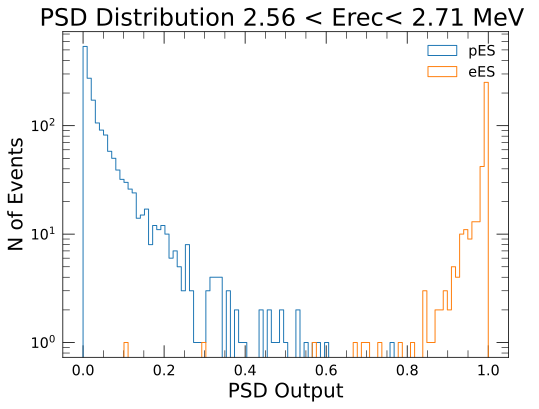

<Figure size 576x432 with 0 Axes>

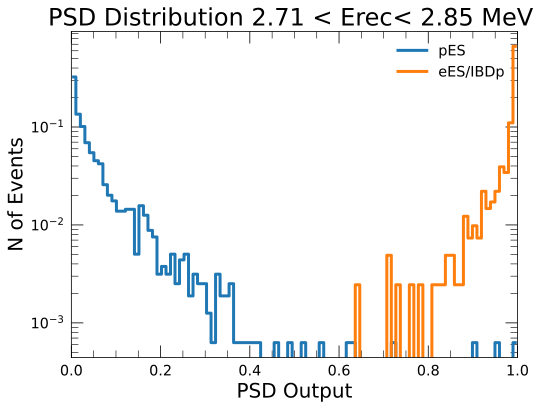

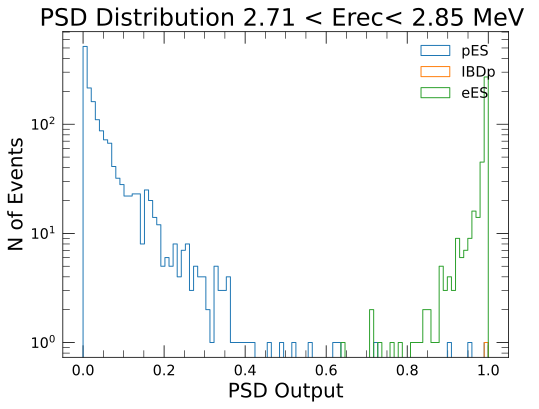

<Figure size 576x432 with 0 Axes>

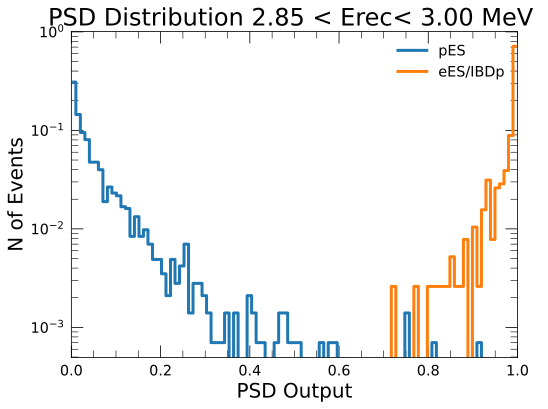

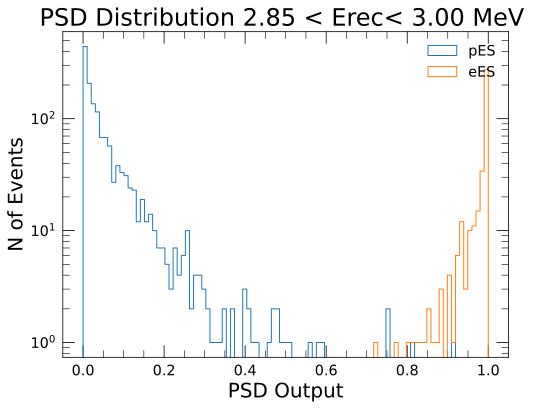

<Figure size 576x432 with 0 Axes>

In [46]:

fig, ax_eff = plt.subplots(2, sharex=True)
discrimination_tool.PlotROCCurvesDiffEBins(bins_Energy=np.linspace(0.2, 3, 20), xlim=(0, 0.1), ylim=(0.5,1),
                                            max_significance=False,
                                           ax_eff=ax_eff)
discrimination_tool.PrintEffDataframe()